# EV Charging Load Analysis & Shift Impact

The goal of this EDA is to look at workplace EV charging behavior, identify temporal usage patterns, and analyze the potential for load shifting to reduce peak demand and improve grid balance. 

### Questions we will be asking:
 1. What are the peak vs off-peak charging behaviors?
 2. How does a market disruption (Covid-19) impact EV charging behaviors?
 3. How much charging behavior is over-provisioned?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
wcd = pd.read_csv("C:\\Users\\crade\\OneDrive\\Desktop\\Portfolio Projects\\Workplace Charging Data\\workplace-charging-data.csv")
wcd.head()
wcd.info()
wcd.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40972 entries, 0 to 40971
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   driverId             40972 non-null  int64  
 1   vehicle_model        33393 non-null  object 
 2   request_entry_time   40972 non-null  object 
 3   expected_departure   40972 non-null  object 
 4   station              40972 non-null  object 
 5   start_date_time      14581 non-null  object 
 6   end_date_time        14581 non-null  object 
 7   start_charge         36601 non-null  object 
 8   termin_charge        36601 non-null  object 
 9   controlled_duration  4763 non-null   float64
 10  miles_requested      40972 non-null  int64  
 11  max_charge_power     36601 non-null  float64
 12  kwh_requested        40972 non-null  float64
 13  energy_charged       40485 non-null  float64
 14  cost_for_session     40485 non-null  float64
 15  afterPaid            40972 non-null 

,driverId,controlled_duration,miles_requested,max_charge_power,kwh_requested,energy_charged,cost_for_session
count,40972.000000,4763.000000,40972.000000,36601.000000,40972.000000,40485.000000,40485.000000
mean,1618.263839,0.172773,49.996315,3.988719,15.988638,10.993281,1.158521
std,1830.418774,0.715521,34.027218,1.811961,10.192720,7.741870,0.836189
min,0.000000,0.000000,-396.000000,0.001000,-110.880000,0.000000,0.000000
25%,96.000000,0.000000,30.000000,3.059189,9.000000,5.906387,0.621666
50%,2175.000000,0.000000,40.000000,3.312000,14.000000,9.403956,0.976125
75%,2694.000000,0.000000,60.000000,6.281650,19.500000,13.675409,1.412800
max,21422.000000,8.133330,300.000000,7.479000,99.750000,68.312450,9.779800


In [3]:
wcd.isnull().sum()

driverId                   0
vehicle_model           7579
request_entry_time         0
expected_departure         0
station                    0
start_date_time        26391
end_date_time          26391
start_charge            4371
termin_charge           4371
controlled_duration    36209
miles_requested            0
max_charge_power        4371
kwh_requested              0
energy_charged           487
cost_for_session         487
afterPaid                  0
dtype: int64

Let's remove rows where there are no datetimes.

In [4]:
wcd = wcd.dropna(subset=['start_charge', 'termin_charge'])
wcd = wcd.dropna(subset=['start_date_time', 'end_date_time'])

In [5]:
wcd.isnull().sum()

driverId                   0
vehicle_model           5574
request_entry_time         0
expected_departure         0
station                    0
start_date_time            0
end_date_time              0
start_charge               0
termin_charge              0
controlled_duration    10696
miles_requested            0
max_charge_power           0
kwh_requested              0
energy_charged             0
cost_for_session           0
afterPaid                  0
dtype: int64

This looks better. This will help us get a better sense of our data.

First I will turn the date columns into datetime types. 
Then I am going to create new columns to give us the time a vehicle was occupying a space (plugin_duration) and the time a vehicle was actually being charged (charging_duration). 

Plugin_duration is 

In [6]:
wcd['start_date_time'] = pd.to_datetime(wcd['start_date_time'])
wcd['end_date_time'] = pd.to_datetime(wcd['end_date_time'])
wcd['start_charge'] = pd.to_datetime(wcd['start_charge'])
wcd['termin_charge'] = pd.to_datetime(wcd['termin_charge'])
wcd['plugin_duration'] = (wcd['end_date_time'] - wcd['start_date_time']).dt.total_seconds() / 3600
wcd['charging_duration'] = (wcd['termin_charge'] - wcd['start_charge']).dt.total_seconds() / 3600

We will now make a column calculating the efficiency.

### Peak vs Off-Peak Behavior

In [7]:
wcd['start_hour'] = wcd['start_charge'].dt.hour

In [8]:
hourly_counts = wcd.groupby('start_hour').size()
print(hourly_counts)

start_hour
0       14
1        1
2        4
3        1
4        6
5       90
6      624
7     1786
8     2981
9     2061
10     816
11     505
12     626
13     724
14     245
15     130
16      48
17      18
18       9
19       3
20       4
dtype: int64


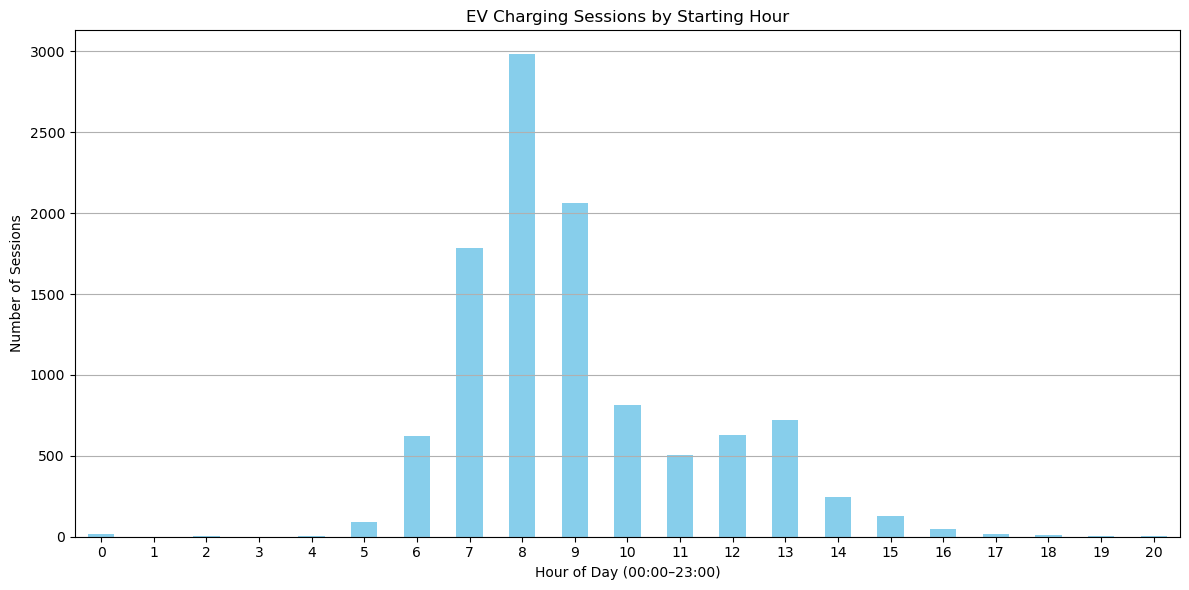

In [36]:
hourly_counts.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('EV Charging Sessions by Starting Hour')
plt.xlabel('Hour of Day (00:00–23:00)')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Now that we can see the peak vs off peak hours, we should see how much energy is being used during each of these. This could give us insight into how we could manage efficiency and prevent load stress.

In [10]:
wcd['efficiency'] = wcd['energy_charged'] / wcd['kwh_requested']
hourly_efficiency = wcd.groupby('start_hour')['efficiency'].mean()

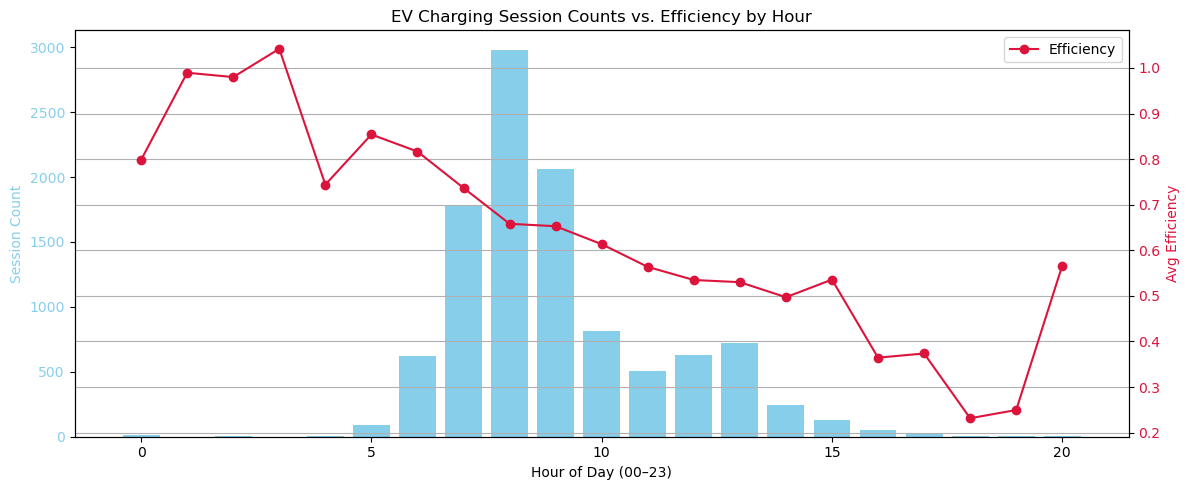

In [34]:
fig, ax1 = plt.subplots(figsize=(12, 5))


ax1.bar(hourly_counts.index, hourly_counts.values, color='skyblue', label='Session Count')
ax1.set_xlabel('Hour of Day (00–23)')
ax1.set_ylabel('Session Count', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

ax2 = ax1.twinx()
ax2.plot(hourly_efficiency.index, hourly_efficiency.values, color='crimson', label='Efficiency', marker='o')
ax2.set_ylabel('Avg Efficiency', color='crimson')
ax2.tick_params(axis='y', labelcolor='crimson')

plt.title('EV Charging Session Counts vs. Efficiency by Hour')
plt.grid(True)
fig.tight_layout()
plt.legend()
plt.show()


I am going to add columns for time spent on the charger after it has been finished, energy rate, then finally a column for and overprovisioning flag.

In [12]:
wcd['time_not_charging'] = (wcd['plugin_duration'] - wcd['charging_duration']) / (wcd['plugin_duration']).clip(lower=0)

wcd['energy_rate'] = (wcd['energy_charged'] / wcd['charging_duration'])

In [13]:
wcd['over_provisioning_flag'] = (wcd['energy_rate'] < wcd['energy_rate'].median()) | (wcd['time_not_charging'] > wcd['time_not_charging'].quantile(0.95)) | (wcd['efficiency'] < 0.7)

## How does a market disruption (Covid-19) impact EV charging behaviors?


In [14]:
wcd['year'] = pd.DatetimeIndex(wcd['start_charge']).year
wcd['month'] = pd.DatetimeIndex(wcd['start_charge']).month

We will create three new dataframes: PreCovid data, Covid data, and PostCovid data

In [15]:
covid_wcd = wcd[((wcd['year'] == 2020) & (wcd['month'] >= 3)) | (wcd['year'] == 2021) & (wcd['month'] <= 6)]
preCovid_wcd = wcd[(wcd['year'] < 2020) | ((wcd['year'] == 2020) & (wcd['month'] < 3))]
postCovid_wcd = wcd[(wcd['year'] > 2021) | ((wcd['year'] == 2021) & (wcd['month'] > 6))]

In [16]:
covid_wcd.head(10)

,driverId,vehicle_model,request_entry_time,expected_departure,station,start_date_time,end_date_time,start_charge,termin_charge,controlled_duration,...,afterPaid,plugin_duration,charging_duration,start_hour,efficiency,time_not_charging,energy_rate,over_provisioning_flag,year,month
2127,5023,Nissan LEAF,2020-03-01T01:30:46-05:00,2020-03-01T05:04:46-05:00,06A,2020-03-01 06:52:10,2020-03-01 15:45:09,2020-03-01 06:34:58,2020-03-01 11:28:29,NaN,...,True,8.883056,4.891944,6,1.001200,0.449295,2.046630,True,2020,3
2128,2574,Nissan LEAF,2020-03-01T05:33:19-05:00,2020-03-01T17:33:19-05:00,LV22-14,2020-03-01 10:33:46,2020-03-01 17:52:46,2020-03-01 10:33:22,2020-03-01 13:03:15,NaN,...,True,7.316667,2.498056,10,0.222775,0.658580,3.567174,True,2020,3
2129,3085,NaN,2020-03-02T02:05:11-05:00,2020-03-02T09:45:11-05:00,LV21-01,2020-03-02 07:05:43,2020-03-02 16:19:58,2020-03-02 07:05:17,2020-03-02 11:45:09,NaN,...,True,9.237500,4.664444,7,0.598292,0.495053,3.078394,True,2020,3
2130,2574,Nissan LEAF,2020-03-02T02:21:11-05:00,2020-03-02T14:21:11-05:00,LV22-14,2020-03-02 07:21:50,2020-03-02 17:55:19,2020-03-02 07:21:19,2020-03-02 11:34:41,NaN,...,True,10.558056,4.222778,7,0.419275,0.600042,3.971556,True,2020,3
2131,2692,Chevy Volt,2020-03-02T02:25:12-05:00,2020-03-02T14:25:12-05:00,LV32-16,2020-03-02 07:28:28,2020-03-02 16:00:59,2020-03-02 07:25:15,2020-03-02 10:06:26,NaN,...,True,8.541944,2.686389,7,0.819500,0.685506,2.440451,True,2020,3
2132,2815,NaN,2020-03-02T02:40:02-05:00,2020-03-02T11:25:02-05:00,LV22-15,2020-03-02 07:40:21,2020-03-02 16:55:39,2020-03-02 07:40:04,2020-03-02 12:31:05,NaN,...,True,9.255000,4.850278,7,0.896437,0.475929,2.957150,True,2020,3
2133,3050,Nissan LEAF,2020-03-02T02:40:35-05:00,2020-03-02T12:45:35-05:00,LV22-12,2020-03-02 07:40:40,2020-03-02 10:18:45,2020-03-02 07:40:38,2020-03-02 10:18:40,NaN,...,True,2.634722,2.633889,7,0.281562,0.000316,3.420797,True,2020,3
2134,517,Nissan LEAF,2020-03-02T02:55:52-05:00,2020-03-02T09:37:52-05:00,07A,2020-03-02 07:56:18,2020-03-02 16:05:26,2020-03-02 08:00:05,2020-03-02 09:59:17,NaN,...,True,8.152222,1.986667,8,1.001300,0.756304,5.040101,False,2020,3
2135,2633,Chevy Volt,2020-03-02T02:59:34-05:00,2020-03-02T12:17:34-05:00,LV22-18,2020-03-02 07:59:45,2020-03-02 18:00:25,2020-03-02 07:59:37,2020-03-02 11:46:20,NaN,...,True,10.011111,3.778611,7,0.535000,0.622558,2.831728,True,2020,3
2136,402,Chevy Spark,2020-03-02T03:03:00-05:00,2020-03-02T11:13:00-05:00,LV22-13,2020-03-02 08:03:16,2020-03-02 18:19:51,2020-03-02 08:03:02,2020-03-02 14:47:02,NaN,...,True,10.276389,6.733333,8,0.606400,0.344776,1.013168,True,2020,3


In terms of metrics, we will look at the difference of peak charging hours, efficiency by hour, and average cost per session for pre, post and during covid-19.

We will start with charging session peaks vs efficiency by the hour pre-covid.

In [17]:
pre_hourly_counts = preCovid_wcd.groupby('start_hour').size()
pre_hourly_efficiency = preCovid_wcd.groupby('start_hour')['efficiency'].mean()

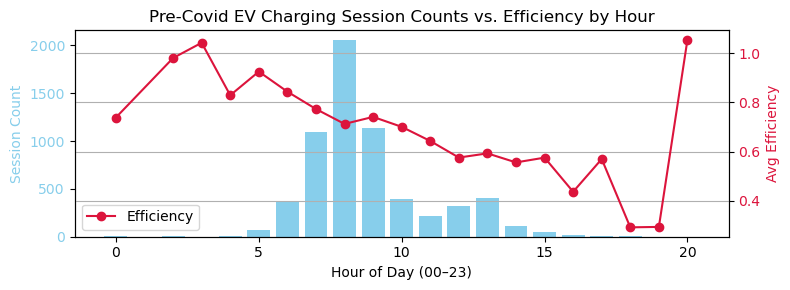

In [33]:
fig, ax1 = plt.subplots(figsize=(8, 3))


ax1.bar(pre_hourly_counts.index, pre_hourly_counts.values, color='skyblue', label='Session Count')
ax1.set_xlabel('Hour of Day (00–23)')
ax1.set_ylabel('Session Count', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

ax2 = ax1.twinx()
ax2.plot(pre_hourly_efficiency.index, pre_hourly_efficiency.values, color='crimson', label='Efficiency', marker='o')
ax2.set_ylabel('Avg Efficiency', color='crimson')
ax2.tick_params(axis='y', labelcolor='crimson')

plt.title('Pre-Covid EV Charging Session Counts vs. Efficiency by Hour')
plt.grid(True)
fig.tight_layout()
plt.legend()
plt.show()

Now let's look at the charging session times vs efficiency by the hour during covid.

In [19]:
covid_hourly_counts = covid_wcd.groupby('start_hour').size()
covid_hourly_efficiency = covid_wcd.groupby('start_hour')['efficiency'].mean()

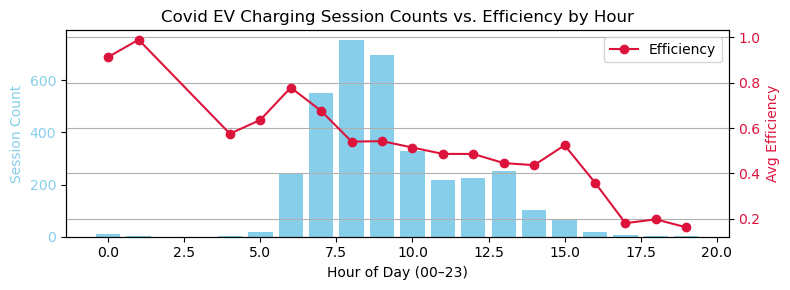

In [32]:
fig, ax1 = plt.subplots(figsize=(8, 3))


ax1.bar(covid_hourly_counts.index, covid_hourly_counts.values, color='skyblue', label='Session Count')
ax1.set_xlabel('Hour of Day (00–23)')
ax1.set_ylabel('Session Count', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

ax2 = ax1.twinx()
ax2.plot(covid_hourly_efficiency.index, covid_hourly_efficiency.values, color='crimson', label='Efficiency', marker='o')
ax2.set_ylabel('Avg Efficiency', color='crimson')
ax2.tick_params(axis='y', labelcolor='crimson')

plt.title('Covid EV Charging Session Counts vs. Efficiency by Hour')
plt.grid(True)
fig.tight_layout()
plt.legend()
plt.show()

We can see that during covid, the peak hours stayed similar to the peak hours of the pre covid data but the efficiency dropped significantly (roughly 20% across the board). Then around 8:00 pm, instead of the efficiency rising to 100%, during covid the efficiency continuted to drop even in the later hours of the night. 

Finally, we will look at the post covid data.

In [21]:
post_hourly_counts = postCovid_wcd.groupby('start_hour').size()
post_hourly_efficiency = postCovid_wcd.groupby('start_hour')['efficiency'].mean()

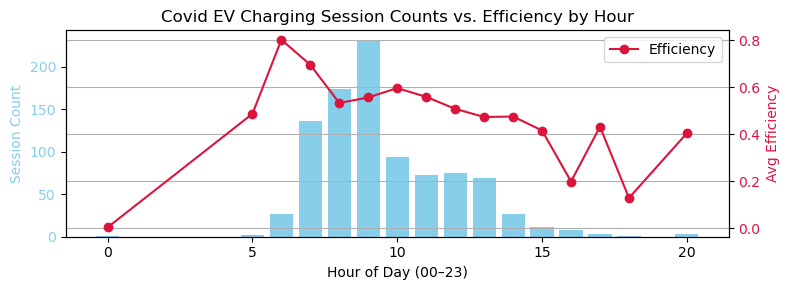

In [31]:
fig, ax1 = plt.subplots(figsize=(8, 3))


ax1.bar(post_hourly_counts.index, post_hourly_counts.values, color='skyblue', label='Session Count')
ax1.set_xlabel('Hour of Day (00–23)')
ax1.set_ylabel('Session Count', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

ax2 = ax1.twinx()
ax2.plot(post_hourly_efficiency.index, post_hourly_efficiency.values, color='crimson', label='Efficiency', marker='o')
ax2.set_ylabel('Avg Efficiency', color='crimson')
ax2.tick_params(axis='y', labelcolor='crimson')

plt.title('Covid EV Charging Session Counts vs. Efficiency by Hour')
plt.grid(True)
fig.tight_layout()
plt.legend()
plt.show()

In the post covid data, the efficiency stayed similar to the covid data but in the later hours of the night the effiicency was staggered between ~20% and 40%.

In conclusion, covid brought about a significant downturn in efficiency. Our data does give us more sessions pre covid than post and during covid but the dates of the data range from 2019 until 2021, capturing most of its data pre covid.

Now we can view the average costs per session between the 3 data sets.

In [23]:
print(f'The average cost per session in the entire data set is ${wcd.cost_for_session.mean().round(2)}.')

The average cost per session in the entire data set is $1.27.


In [24]:
print(f'The average cost per session in the pre-covid data set is ${preCovid_wcd.cost_for_session.mean().round(2)}0.')

The average cost per session in the pre-covid data set is $1.30.


In [25]:
print(f'The average cost per session in the covid data set is ${covid_wcd.cost_for_session.mean().round(2)}.')

The average cost per session in the covid data set is $1.22.


In [26]:
print(f'The average cost per session in the post-covid data set is ${postCovid_wcd.cost_for_session.mean().round(2)}.')

The average cost per session in the post-covid data set is $1.32.


Before and after covid the average costs were relatively similar, but during covid the prices fell quite a bit. 

### With the market disruption (covid-19) the efficiency both during and after dropped with the prices falling during covid but rising to slightly higher than before the disruption.

## How much charging behavior is over-provisioned?

Finally, I will look at the overprovisioning behavior across the post-covid, pre-covid, during covid and the entire dataset.  

In [27]:
print(f'The percentage of the overall data set that was overprovisioned was %{wcd.over_provisioning_flag.mean() * 100:.2f}.')

The percentage of the overall data set that was overprovisioned was %75.74.


In [28]:
print(f'The percentage of the pre-covid data set that was overprovisioned was %{preCovid_wcd.over_provisioning_flag.mean() * 100:.2f}.')

The percentage of the pre-covid data set that was overprovisioned was %71.33.


In [29]:
print(f'The percentage of the covid data set that was overprovisioned was %{covid_wcd.over_provisioning_flag.mean() * 100:.2f}.')

The percentage of the covid data set that was overprovisioned was %84.03.


In [30]:
print(f'The percentage of the post-covid data set that was overprovisioned was %{postCovid_wcd.over_provisioning_flag.mean() * 100:.2f}.')

The percentage of the post-covid data set that was overprovisioned was %74.30.


It is obvious to see that prior to covid and after covid the over provisioning was at its lowest on average but during covid it rose by over 12% from the years before.

In [37]:
summary = pd.DataFrame({
    'Avg Efficiency': [
        preCovid_wcd['efficiency'].mean(),
        covid_wcd['efficiency'].mean(),
        postCovid_wcd['efficiency'].mean(),
        wcd['efficiency'].mean()
    ],
    'Avg Cost per Session ($)': [
        preCovid_wcd['cost_for_session'].mean(),
        covid_wcd['cost_for_session'].mean(),
        postCovid_wcd['cost_for_session'].mean(),
        wcd['cost_for_session'].mean()
    ],
    'Over-Provisioned (%)': [
        preCovid_wcd['over_provisioning_flag'].mean() * 100,
        covid_wcd['over_provisioning_flag'].mean() * 100,
        postCovid_wcd['over_provisioning_flag'].mean() * 100,
        wcd['over_provisioning_flag'].mean() * 100
    ]
})

summary = summary.round({'Avg Efficiency': 2, 'Avg Cost per Session ($)': 2, 'Over-Provisioned (%)': 1})


,Avg Efficiency,Avg Cost per Session ($),Over-Provisioned (%)
0,0.71,1.30,71.3
1,0.56,1.22,84.0
2,0.56,1.32,74.3
3,0.65,1.27,75.7


In [46]:
periods = ['Pre-Covid', 'During Covid', 'Post-Covid', 'Overall']

print(f"""
Conclusion:

During the analysis of workplace EV charging behavior we saw that:

- Pre-Covid, the average charging efficiency was %{summary.loc[0, 'Avg Efficiency']*100:.2f}, 
  the average cost per session was ${summary.loc[0, 'Avg Cost per Session ($)']}, 
  and {summary.loc[0, 'Over-Provisioned (%)']}% of sessions were over-provisioned.

- During Covid, efficiency dropped to %{summary.loc[1, 'Avg Efficiency']*100:.2f}, 
  costs fell slightly to ${summary.loc[1, 'Avg Cost per Session ($)']}, 
  and over-provisioning increased to {summary.loc[1, 'Over-Provisioned (%)']}%.

- Post-Covid, efficiency partially recovered to %{summary.loc[2, 'Avg Efficiency']*100:.2f}, 
  average costs rose to ${summary.loc[2, 'Avg Cost per Session ($)']}, 
  and over-provisioning decreased to {summary.loc[2, 'Over-Provisioned (%)']}%.

- Overall, across the entire dataset, the average efficiency was %{summary.loc[3, 'Avg Efficiency']*100:.2f}, 
  the cost per session was ${summary.loc[3, 'Avg Cost per Session ($)']}, 
  and {summary.loc[3, 'Over-Provisioned (%)']}% of sessions were over-provisioned.
""")


Conclusion:

During the analysis of workplace EV charging behavior we saw that:

- Pre-Covid, the average charging efficiency was %71.00, 
  the average cost per session was $1.3, 
  and 71.3% of sessions were over-provisioned.

- During Covid, efficiency dropped to %56.00, 
  costs fell slightly to $1.22, 
  and over-provisioning increased to 84.0%.

- Post-Covid, efficiency partially recovered to %56.00, 
  average costs rose to $1.32, 
  and over-provisioning decreased to 74.3%.

- Overall, across the entire dataset, the average efficiency was %65.00, 
  the cost per session was $1.27, 
  and 75.7% of sessions were over-provisioned.

